In [83]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import numpy as np
from PIL import Image
import ncem

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 0
sc.settings.figdir = figdir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Scanpy 1.7.2, on 2021-06-17 12:06.


In [84]:
base_path = '/Users/anna.schaar/phd/'

In [85]:
datadir = base_path + "datasets/"

# MERFISH - brain

In [5]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='zhang',
    data_path=datadir + 'zhang/',
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)

Loading data from raw files
registering celldata


Trying to set attribute `.uns` of view, copying.


collecting image-wise celldata
adding graph-level covariates
Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611


In [6]:
interpreter.data.celldata.uns['metadata']

{'lateral_resolution': 0.105,
 'fn': 'preprocessed_zhang.h5ad',
 'image_col': 'slice_id',
 'pos_cols': ['center_x', 'center_y'],
 'cluster_col': 'subclass',
 'patient_col': 'mouse'}

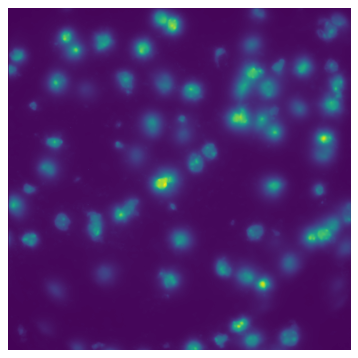

In [86]:
fn = f"{datadir}zhang/dataset1_sample3_488.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

img = sq.im.ImageContainer(images[:, :, 167])
sq.im.process(img)
img.show('image_smooth', figsize=(5,5))

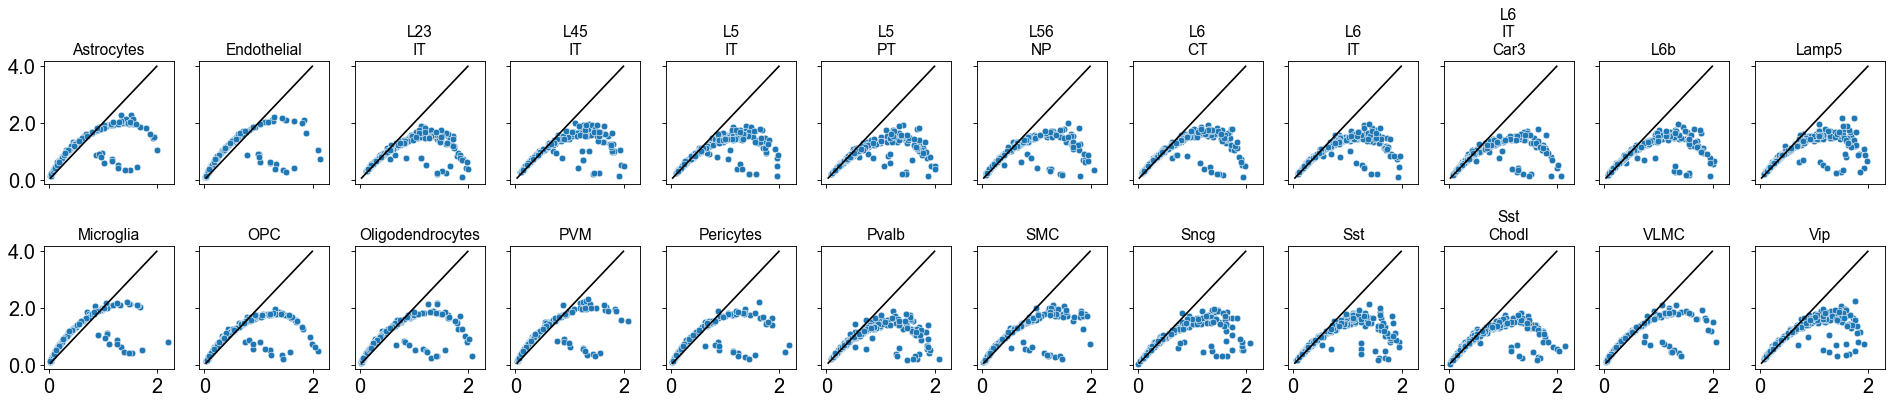

In [64]:
sc.set_figure_params(scanpy=True, fontsize=18)
interpreter.data.plot_noise_structure(
    undefined_type='other',
)

AnnData object with n_obs × n_vars = 27638 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates'
    obsm: 'spatial', 'node_types'


  0%|          | 0/1000 [00:00<?, ?permutation/s]

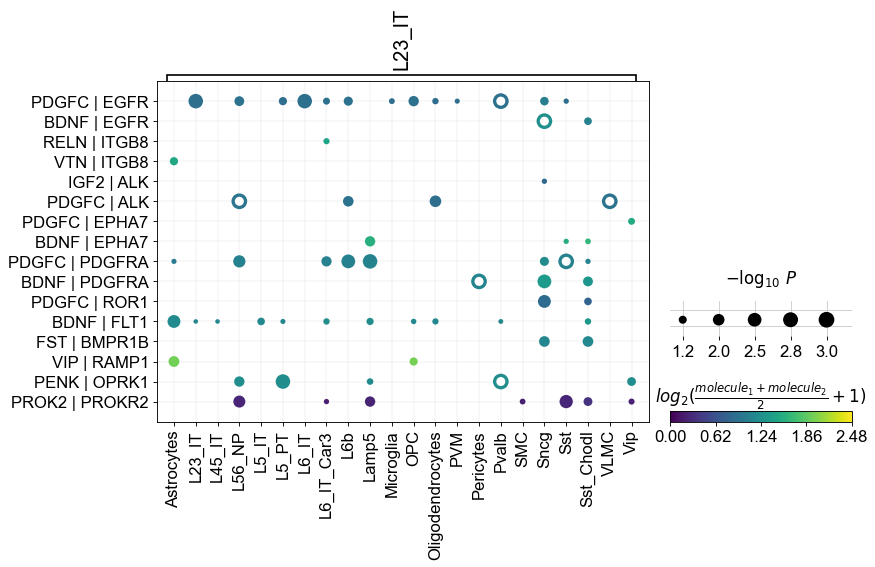

In [7]:
adata = interpreter.data.plot_ligrec(
    fraction=0.1,
    source_groups='L23_IT',
    undefined_type='other',
)

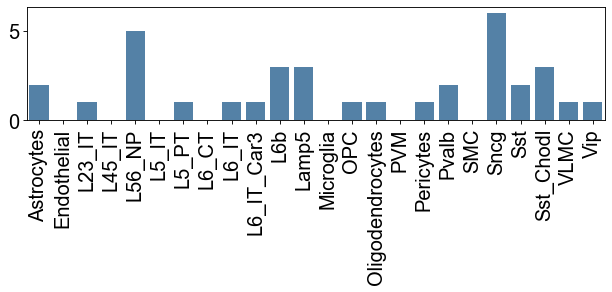

In [8]:
interpreter.data.plot_ligrec_barplot(
    adata,
    source_group='L23_IT',
)

n cells:  7656


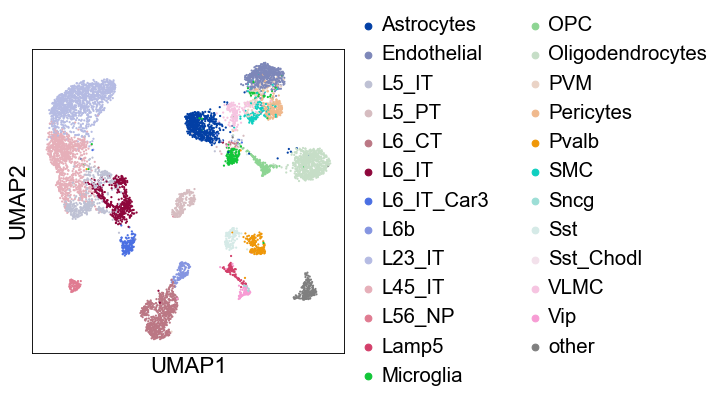

AnnData object with n_obs × n_vars = 7656 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample', 'louvain'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors', 'neighbors', 'louvain', 'umap', 'subclass_colors'
    obsm: 'spatial', 'node_types', 'X_pca', 'X_umap'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances', 'distances', 'connectivities'

In [10]:
interpreter.data.plot_umap(
    image_key= "mouse1_slice153",
    n_neighbors=10,
    n_pcs=35
)

Trying to set attribute `.uns` of view, copying.


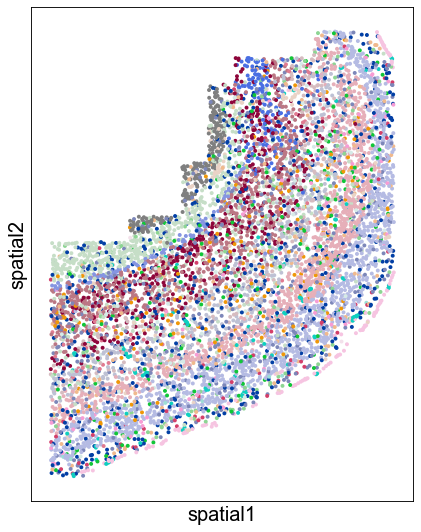

AnnData object with n_obs × n_vars = 7626 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors', 'subclass_colors'
    obsm: 'spatial', 'node_types'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances'

In [11]:
interpreter.data.plot_spatial(
    image_key= "mouse1_slice153",
    clean_view=True
)

... storing 'L23_ITsub-states' as categorical


n cells:  1204
L23_IT0    316
L23_IT1    314
L23_IT2    313
L23_IT3    133
L23_IT4    128
Name: L23_ITsub-states, dtype: int64


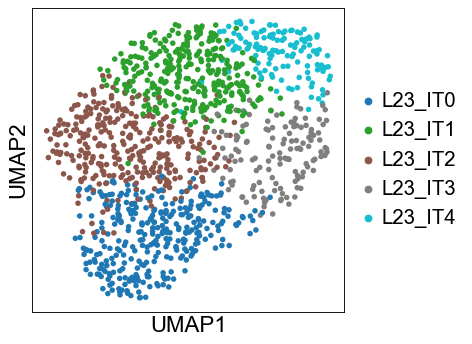

In [21]:
adata = interpreter.data.plot_umap(
    image_key= "mouse1_slice153",
    target_cell_type='L23_IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10'
)

Trying to set attribute `.uns` of view, copying.


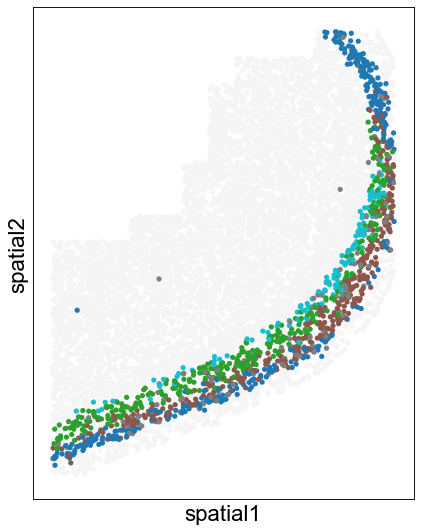

In [22]:
interpreter.data.plot_spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L23_IT',
    clean_view=True
)

In [38]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L45 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L56 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L23 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

In [54]:
adata, log_pval, fold_change = interpreter.data.cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L23 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


n cells:  1204
L23 IT 0    316
L23 IT 1    314
L23 IT 2    313
L23 IT 3    133
L23 IT 4    128
Name: L23 IT_sub-states, dtype: int64


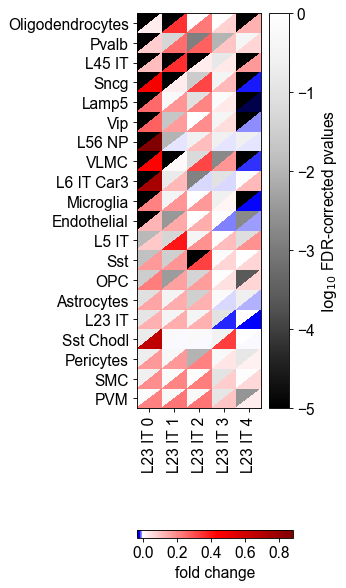

In [57]:
interpreter.data.plot_cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change
)

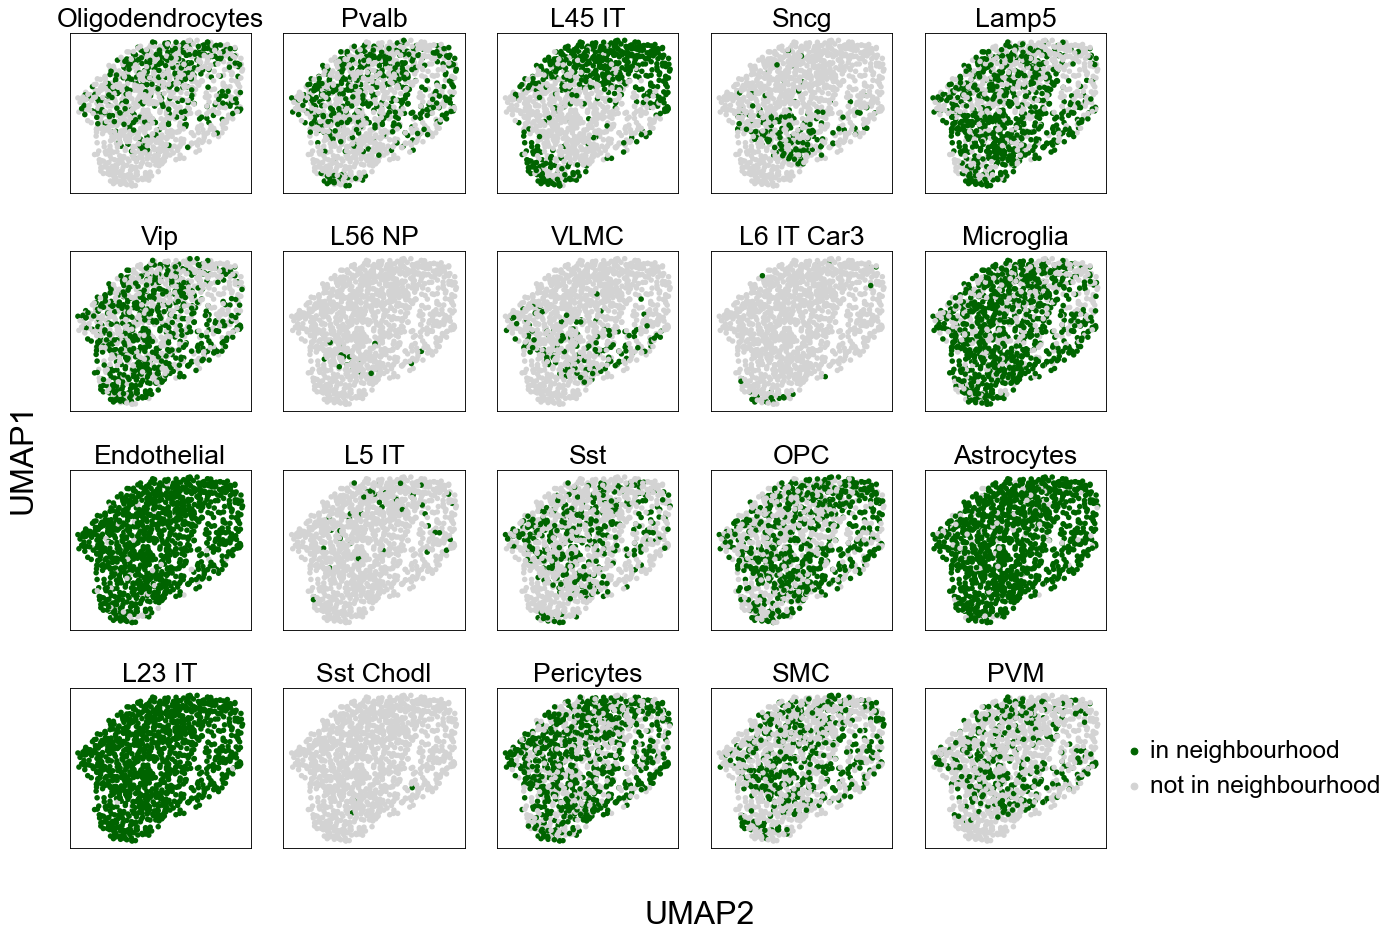

In [61]:
interpreter.data.plot_cluster_enrichment_umaps(adata, filter_titles)

AnnData object with n_obs × n_vars = 7439 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors'
    obsm: 'spatial', 'node_types'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances'


  0%|          | 0/1000 [00:00<?, ?permutation/s]

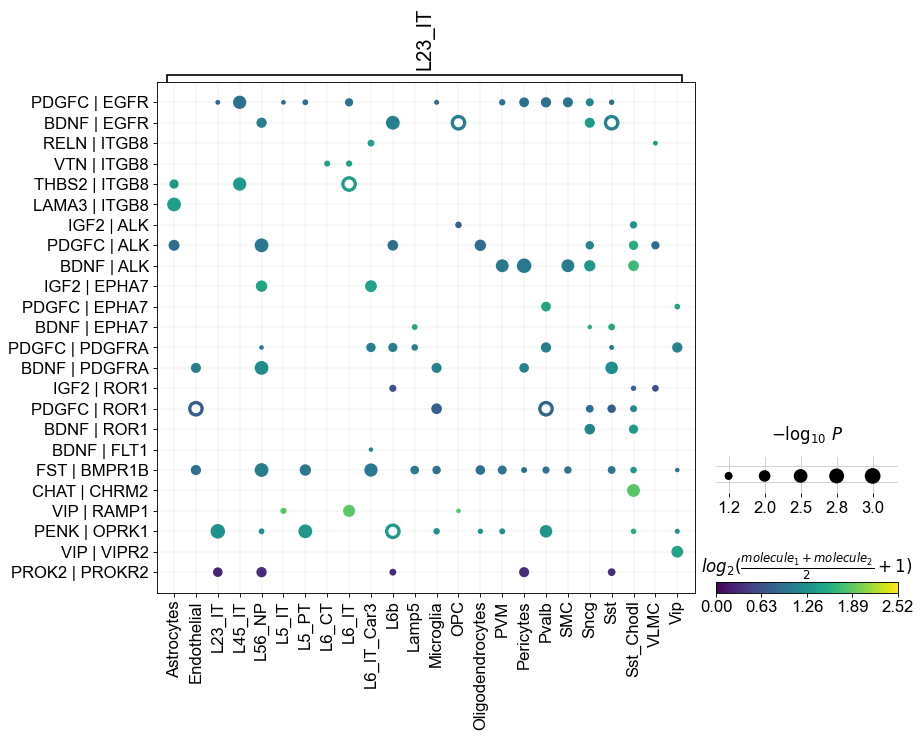

In [14]:
adata = interpreter.data.plot_ligrec(
    image_key= "mouse1_slice153",
    source_groups='L23_IT',
    undefined_type='other',
)

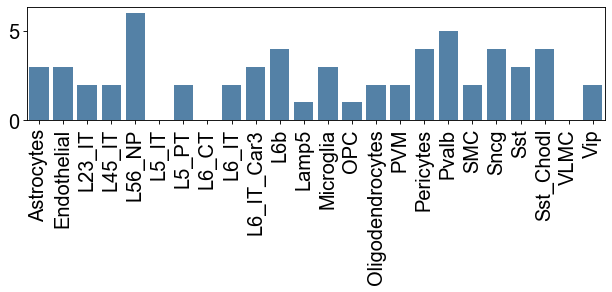

In [15]:
interpreter.data.plot_ligrec_barplot(
    adata,
    source_group='L23_IT',
)

n cells:  6963


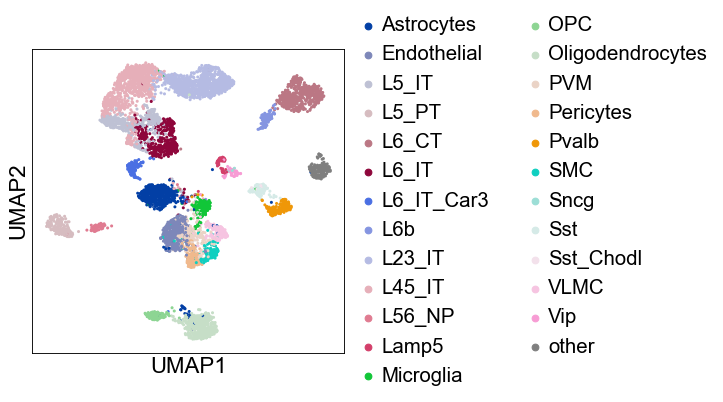

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample', 'louvain'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors', 'neighbors', 'louvain', 'umap', 'subclass_colors'
    obsm: 'spatial', 'node_types', 'X_pca', 'X_umap'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances', 'distances', 'connectivities'

In [17]:
interpreter.data.plot_umap(
    image_key= "mouse1_slice162",
    n_neighbors=10,
    n_pcs=35,
    size=30
)

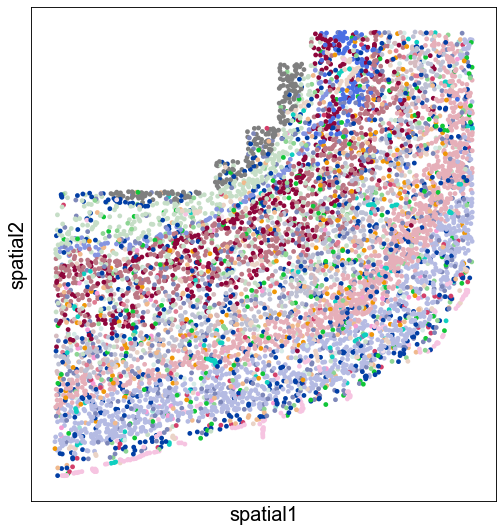

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'mouse', 'slice', 'dataset', 'sample'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors', 'subclass_colors'
    obsm: 'spatial', 'node_types'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances'

In [20]:
interpreter.data.plot_spatial(
    image_key= "mouse1_slice162",
)

... storing 'L23_ITsub-states' as categorical


n cells:  946
L23_IT0    226
L23_IT1    209
L23_IT2    193
L23_IT3    191
L23_IT4    127
Name: L23_ITsub-states, dtype: int64


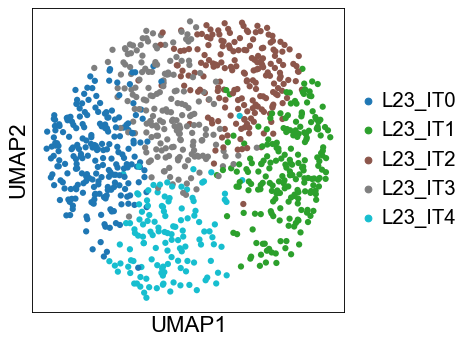

In [18]:
adata = interpreter.data.plot_umap(
    image_key= "mouse1_slice162",
    target_cell_type='L23_IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10',
    copy=True
)

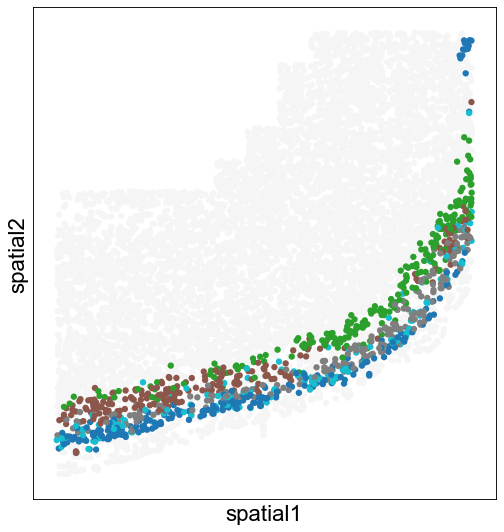

In [19]:
interpreter.data.plot_spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L23_IT',
)

In [65]:
filter_titles = ['L45 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L23 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

In [66]:
adata, log_pval, fold_change = interpreter.data.cluster_enrichment(
    image_key='mouse1_slice162',
    target_cell_type='L23 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


n cells:  946
L23 IT 0    226
L23 IT 1    209
L23 IT 2    193
L23 IT 3    191
L23 IT 4    127
Name: L23 IT_sub-states, dtype: int64


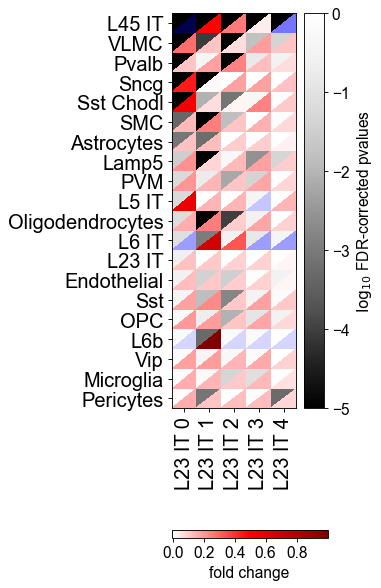

In [67]:
interpreter.data.plot_cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change
)

... storing 'fov' as categorical
... storing 'source type Astrocytes' as categorical
... storing 'source type Endothelial' as categorical
... storing 'source type L23 IT' as categorical
... storing 'source type L45 IT' as categorical
... storing 'source type L56 NP' as categorical
... storing 'source type L5 IT' as categorical
... storing 'source type L5 PT' as categorical
... storing 'source type L6 CT' as categorical
... storing 'source type L6 IT' as categorical
... storing 'source type L6 IT Car3' as categorical
... storing 'source type L6b' as categorical
... storing 'source type Lamp5' as categorical
... storing 'source type Microglia' as categorical
... storing 'source type OPC' as categorical
... storing 'source type Oligodendrocytes' as categorical
... storing 'source type PVM' as categorical
... storing 'source type Pericytes' as categorical
... storing 'source type Pvalb' as categorical
... storing 'source type SMC' as categorical
... storing 'source type Sncg' as categorica

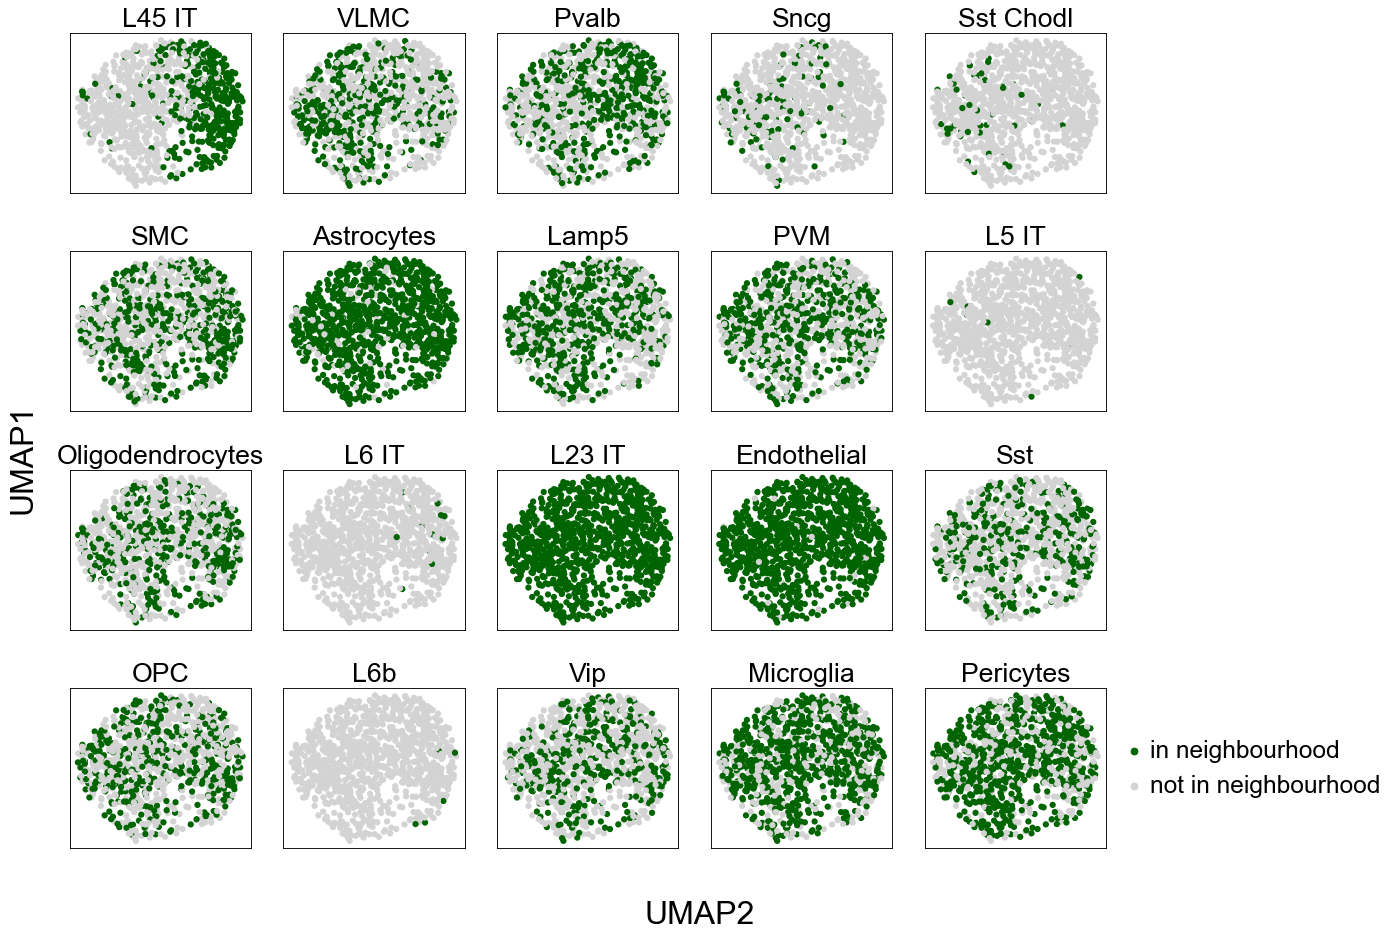

In [68]:
interpreter.data.plot_cluster_enrichment_umaps(adata, filter_titles)

# Chip Cytometry - colon

In [91]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='jarosch',
    data_path=datadir + 'jarosch/',
    radius=40,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)

Trying to set attribute `.uns` of view, copying.


Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 13 distinct celltypes.
Mean of mean node degree per images across images: 4.883873


In [92]:
interpreter.data.celldata.uns['metadata']

{'lateral_resolution': 0.5,
 'fn': 'raw_inflamed_colon_1.h5ad',
 'image_col': 'Annotation',
 'pos_cols': ['X', 'Y'],
 'cluster_col': 'celltype_Level_2',
 'patient_col': None}

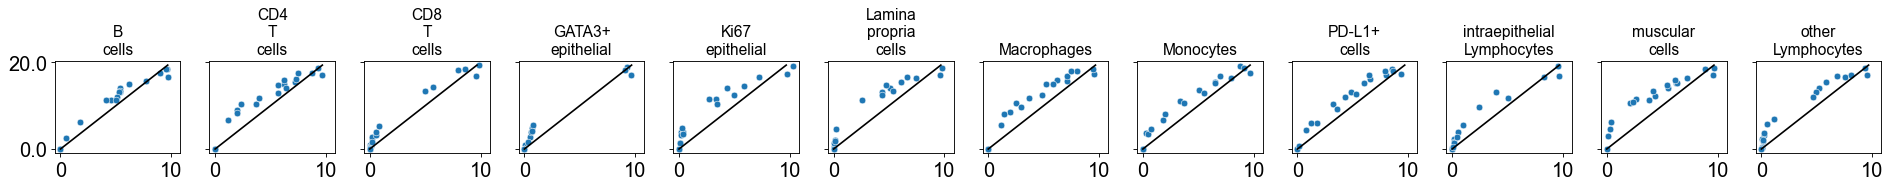

In [93]:
sc.set_figure_params(scanpy=True, fontsize=18)
interpreter.data.plot_noise_structure()

# MIBI TOF - cancer

In [94]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='hartmann',
    data_path=datadir + 'hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates
Loaded 58 images with complete data from 4 patients over 63734 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416425


In [95]:
interpreter.data.celldata.uns['metadata']

{'lateral_resolution': 0.390625,
 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv',
  'scMEP_sample_description.xlsx'],
 'image_col': 'point',
 'pos_cols': ['center_colcoord', 'center_rowcoord'],
 'cluster_col': 'Cluster',
 'patient_col': 'donor'}

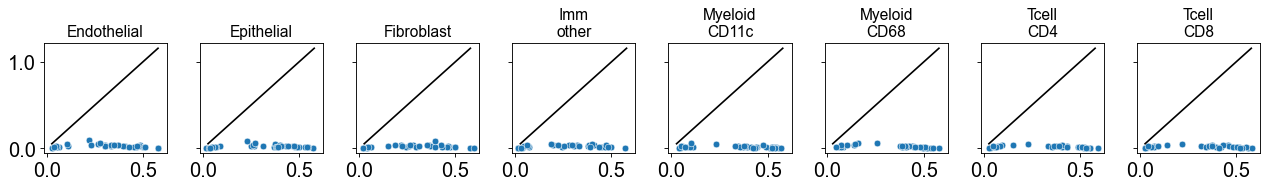

In [96]:
sc.set_figure_params(scanpy=True, fontsize=18)
interpreter.data.plot_noise_structure()

# MELC - tonsils data

In [109]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='pascualreguant',
    data_path=datadir + 'pascualreguant/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates
Loaded 1 images with complete data from 1 patients over 6991 cells with 51 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 19.083107


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [110]:
interpreter.data.celldata.uns['metadata']

{'lateral_resolution': 0.325,
 'fn': ['TONSIL_MFI_nuclei_data_table.xlsx',
  'TONSIL_MFI_membranes_data_table.xlsx'],
 'image_col': 'img_keys',
 'pos_cols': ['Location_Center_X', 'Location_Center_Y'],
 'cluster_col': 'cell_class',
 'patient_col': None}

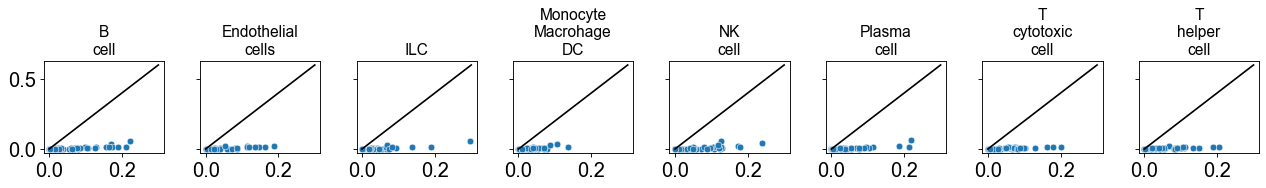

In [111]:
sc.set_figure_params(scanpy=True, fontsize=18)
interpreter.data.plot_noise_structure(
    undefined_type='other',
    min_x=0.0, max_x=0.3
)

# CODEX - cancer

In [112]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='schuerch',
    data_path=datadir + 'schuerch/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


collecting image-wise celldata
adding graph-level covariates
Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 29 distinct celltypes.
Mean of mean node degree per images across images: 10.311835


In [107]:
interpreter.data.celldata.uns['metadata']

{'lateral_resolution': 0.377442,
 'fn': 'CRC_clusters_neighborhoods_markers_NEW.csv',
 'image_col': 'File Name',
 'pos_cols': ['X:X', 'Y:Y'],
 'cluster_col': 'ClusterName',
 'patient_col': 'patients'}

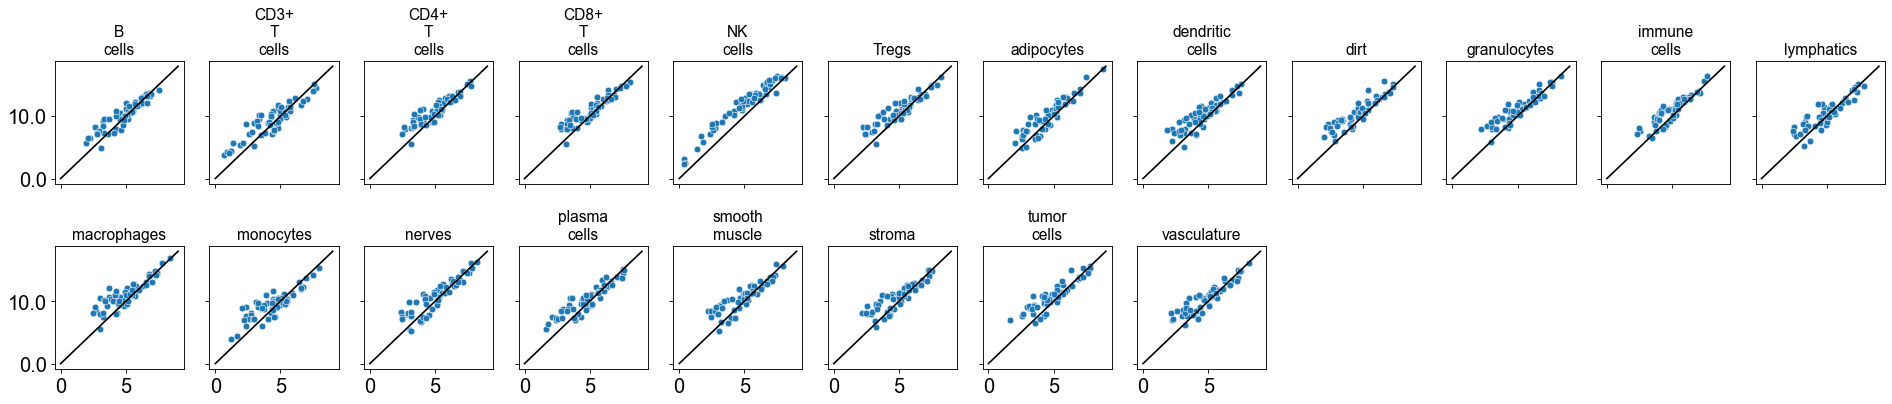

In [108]:
sc.set_figure_params(scanpy=True, fontsize=18)
interpreter.data.plot_noise_structure(
    undefined_type='undefined',
    min_x=0.0, max_x=9.
)